# Building more complex models in NeuroDyn

## Overview

In the "NeuroDyn model" notebook we have learned how we can define Hodgkin-Huxley and NeuroDyn models, how to simulate them, as well as how to fit the parameters of the NeuroDyn model in order to replicate the biophysical data of the squid giant axon.

Although the forms of the NeuroDyn currents are fixed to the forms of the three currents of the original Hodgkin-Huxley paper, the chip offers full flexibility in defining the dynamics of the gating variables, as well as changing the conductance parameters such as maximal conductances and reversal potentials. This flexibility allows us to use the NeuroDyn equations to replicate different types of neurons. This notebook provides an introduction to understanding how more complex biological neurons can be replicated within the NeuroDyn architecture



## Neuronal bursting

Bursting is one of the fundamental signalling modes of neurons and is ubiquitous in many different types of neurons [ref]. Intrinsic generation of bursts of spikes stems from the interplay of fast processes that generate individual spikes and the slower processes that modulate the spiking behavior and define the burst duration. You can read more about the details of conductance-based modelling of bursting neurons **biophysics notebook**, as well as from a simplified dynamical analysis of reduced neuronal models **iv notebook**.

We have seen in the previous notebook how NeuroDyn can be set up to replicate the spiking behavior of the Hodgkin-Huxley model. In contrast, bursting models of neurons are generally more complex, consisting of several additional ionic currents that modulate the slower burst-generating process. These currents are mostly calcium-dependent and act to initiate and terminate the fast spike-generating processes dictated by the sodium and potassium currents.

Since we cannot add additional ionic currents to a single NeuroDyn neuron, we can achieve a similar affect by **interconnecting** several NeuroDyn neurons through resistive connections or short circuits.

## Short-circuiting NeuroDyn neurons

Let's try creating a bursting neuron by configuring two NeuroDyn neurons so that the first one provides the fast spike-generating currents, and the second one provides the slow wave-generating currents. We will then short-circuit the two neurons, effectively creating a new neuron with *six* currents ($2x \ [I_l, I_{Na}, I_K]$).

**Remember** that when we short-circuit two neurons like these, the effective membrane capacitance **doubles** due to the parallel interconnection of the membrane capacitors. This effectively doubles the membrane time constant.

### Load the model

First, let's load the model and the required modules:

In [1]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
np.warnings.filterwarnings('ignore', 'overflow')

Next, let's define two NeuroDyn models with different parameters and short-circuit them:

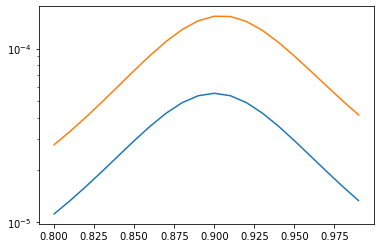

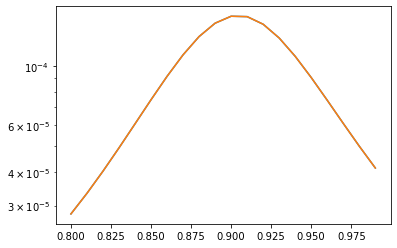

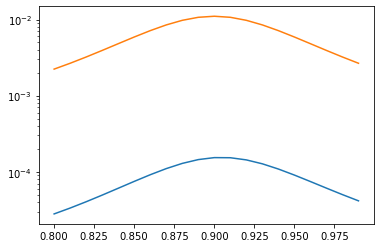

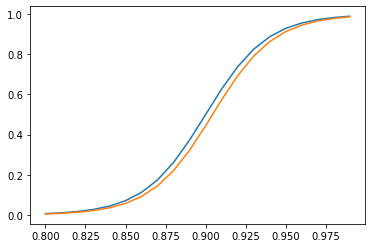

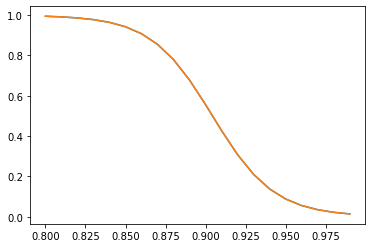

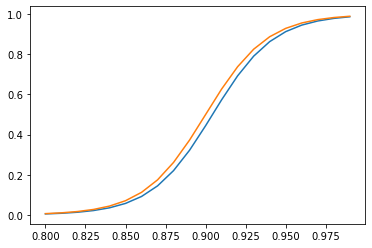

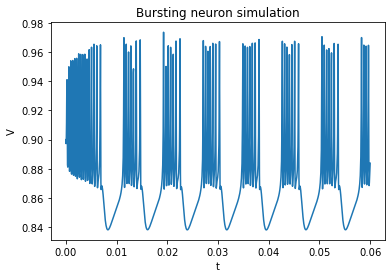

In [12]:
# parameters from joe's simulations

# Maximal conductances
dg1 = np.array([500, 500, 12])
dg2 = np.array([500, 500, 0])

# Reversal potentials
dE1 = np.array([500, -1000, -100])
dE2 = np.array([350, -1000, 0])

# Sigmoid biases
dIbm = np.array([[0, 0, 0, 0, 1000, 0, 0], [0, 0, 1000, 0, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
dIb1 = [dIbm, dIbh, dIbn]

sf = 2.0
dIbm = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 10//sf, 0, 0], [0, 0, 10//sf, 0, 0, 0, 0]])

dIb2 = [dIbm, dIbh, dIbn]

# Analog values (same for both)
V_ref = 0.9
I_master = 33e-9
I_voltage = 230e-9
I_ref = 100e-9

# Create two neurons with different parameters
capacitance_scaling = 0.2 # scale the capacitance to increase the dynamic range
neuron1 = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)
neuron2 = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)

# Short circuit the neurons
bursting_neuron = ShortCircuit([neuron1, neuron2])

# Plot the gating variable functions
V = np.arange(V_ref - 0.1, V_ref + 0.1, 0.01)

# Tau functions
plt.figure()
plt.semilogy(V, neuron1.m.tau(V), V, neuron2.m.tau(V))
plt.figure()
plt.semilogy(V, neuron1.h.tau(V), V, neuron2.h.tau(V))
plt.figure()
plt.semilogy(V, neuron1.n.tau(V), V, neuron2.n.tau(V))

# Steady-state functions
plt.figure()
plt.plot(V, neuron1.m.inf(V), V, neuron2.m.inf(V))
plt.figure()
plt.plot(V, neuron1.h.inf(V), V, neuron2.h.inf(V))
plt.figure()
plt.plot(V, neuron1.n.inf(V), V, neuron2.n.inf(V))

I0 = 0e-10
Iapp = lambda t: I0

T = 0.06
trange = (0, T)

sol = bursting_neuron.simulate(trange,[V_ref,0,0,0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Bursting neuron simulation')
plt.plot(sol.t, sol.y[0])
plt.show()